# 公司层面的事件研究

这是一个用于分析公司层面事件对股价影响的金融研究工具，核心功能是计算异常收益（AR），并通过可视化展示事件对股价的影响。

仍有一些代码需要调整，如有需要请联系我。sjs@mail.bnu.edu.cn

## 合并数据集

In [1]:
import pandas as pd
import sqlite3 as sq
import os
import matplotlib.pyplot as plt
import glob
from datetime import datetime
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm
from pandas.tseries.offsets import QuarterEnd

In [3]:
def read_and_merge_financial_statements():
    """
    读取并合并资产负债表、利润表、现金流量表，生成包含财务指标的数据集。
    数据来源：CSMAR三表
    """
    # 读取并预处理资产负债表
    bas = pd.read_csv('FS_Combas.csv', encoding='utf-8-sig')
    bas = bas[bas['Typrep'] == 'A'].drop_duplicates()
    bas_cols = ['Stkcd', 'Accper', 'Typrep', 'ShortName', 'IfCorrect', 'DeclareDate']
    a_cols = [col for col in bas.columns if col.startswith('A') and col not in bas_cols]
    bas_filtered = bas[bas_cols + a_cols]

    # 读取并预处理利润表
    comin = pd.read_csv('FS_Comins.csv', encoding='utf-8-sig')
    comin = comin[comin['Typrep'] == 'A'].drop_duplicates()
    comin_cols = ['Stkcd', 'Accper', 'Typrep']
    b_cols = [col for col in comin.columns if col.startswith('B') and col not in comin_cols]
    comin_filtered = comin[comin_cols + b_cols]

    # 读取并预处理现金流量表
    scfd = pd.read_csv('FS_Comscfd.csv', encoding='utf-8-sig')
    scfd = scfd[scfd['Typrep'] == 'A'].drop_duplicates()
    scfd_cols = ['Stkcd', 'Accper', 'Typrep']
    c_cols = [col for col in scfd.columns if col.startswith('C') and col not in scfd_cols]
    scfd_filtered = scfd[scfd_cols + c_cols]

    # 合并三个表
    merged = pd.merge(bas_filtered, comin_filtered, on=['Stkcd', 'Accper', 'Typrep'], how='inner')
    merged = pd.merge(merged, scfd_filtered, on=['Stkcd', 'Accper', 'Typrep'], how='inner')

    # 去重并处理日期列
    financial_statement = merged.drop_duplicates()
    financial_statement['Accper'] = pd.to_datetime(financial_statement['Accper'], errors='coerce')  # 转换为日期类型
    financial_statement = financial_statement.dropna(subset=['Accper'])  # 去除日期缺失的行
    financial_statement = financial_statement.sort_values(by=['Stkcd', 'Accper'])  # 按股票代码和日期排序

    return financial_statement

In [5]:
financial_df = read_and_merge_financial_statements()

In [7]:
def merge_trading_data():
    """
    合并股票日交易数据（如收益率、成交量等）。
    数据来源：CSMAR三表
    """
    trd_files = glob.glob('TRD_Dalyr*.csv')
    trd_all = pd.concat([pd.read_csv(f,encoding='utf-8-sig') for f in trd_files], ignore_index=True)
    trd_all = trd_all.drop_duplicates()
    trd_all['Trddt'] = pd.to_datetime(trd_all['Trddt'], errors='coerce')  
    trd_all = trd_all.dropna(subset=['Trddt'])  
    trd_data = trd_all.sort_values(by=['Stkcd', 'Trddt'], ascending=[True, True],  kind='stable')
    return trd_data

In [9]:
daily_returns_df = merge_trading_data()

In [11]:
import pandas as pd
import numpy as np
from tqdm import tqdm

def merge_finance_and_trading_data(financial_df, daily_returns_df):
    """
    合并财务数据和交易数据，并添加进度显示
    合并逻辑是：保留每一年的年报数据，和日频数据匹配，例如2023年财报匹配2024-05-01~2025-04-30（中国年报是4月前公布），然后再按照股票代码和日期匹配。
    参数:
        financial_df: 财务数据DataFrame
        daily_returns_df: 日交易数据DataFrame
        
    返回:
        合并并排序后的DataFrame
    """
    # 初始化进度条
    pbar = tqdm(total=6, desc="数据处理进度")
    
    # 1. 转换会计期间为日期格式
    pbar.set_description("转换日期格式")
    financial_df['stkcd'] = financial_df['Stkcd']
    financial_df['Accper'] = pd.to_datetime(financial_df['Accper'])
    pbar.update(1)
    
    # 2. 筛选年度报告（保留每个会计年度最后一条记录）
    pbar.set_description("筛选年度报告")
    annual_finance = (
        financial_df[financial_df['Accper'].dt.month == 12]
        .sort_values('Accper')
        .groupby(['stkcd', financial_df['Accper'].dt.year.rename('fiscal_year')])
        .last()
        .reset_index()
        .rename(columns={'Accper': 'fiscal_year_end'})
    )
    
    pbar.update(1)
    
    # 3. 生成有效区间
    pbar.set_description("生成有效区间")
    annual_finance['valid_start'] = annual_finance['fiscal_year_end'] + pd.offsets.DateOffset(years=1, month=5, day=1)
    annual_finance['valid_end'] = annual_finance['valid_start'] + pd.offsets.DateOffset(years=1, days=-1)
    pbar.update(1)
    
    # 4. 处理交易数据
    pbar.set_description("处理交易数据")
    daily_returns_df['Trddt'] = pd.to_datetime(daily_returns_df['Trddt'])
    daily_returns_df['stkcd'] = daily_returns_df['Stkcd']
    daily_returns_df['match_year'] = np.where(
        daily_returns_df['Trddt'].dt.month >= 5,
        daily_returns_df['Trddt'].dt.year,
        daily_returns_df['Trddt'].dt.year - 1
    )
    daily_returns_df['stkcd'] = daily_returns_df['stkcd'].astype(str).str.zfill(6)
    annual_finance['stkcd'] = annual_finance['stkcd'].astype(str).str.zfill(6)
    pbar.update(1)
    
    # 5. 合并数据
    pbar.set_description("合并数据")
    merged_data = pd.merge_asof(
        daily_returns_df.sort_values('Trddt'),
        annual_finance.sort_values('valid_start'),
        left_on='Trddt',
        right_on='valid_start',
        by='stkcd',
        direction='forward'
    ).query('Trddt <= valid_end')
    pbar.update(1)
    
    # 6. 排序数据
    pbar.set_description("排序数据")
    sorted_data = merged_data.sort_values(
        by=['stkcd', 'Trddt'],
        ascending=[True, True],
        na_position='first'
    ).rename(columns={'Stkcd_x': 'Stkcd'}).reset_index(drop=True)
    pbar.update(1)
    
    pbar.close()
    return sorted_data

In [37]:
stock_df = merge_finance_and_trading_data(financial_df, daily_returns_df)

C:\Users\29229\AppData\Local\Temp\ipykernel_14440\3621320734.py:40: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  annual_finance['valid_start'] = annual_finance['fiscal_year_end'] + pd.offsets.DateOffset(years=1, month=5, day=1)
排序数据: 100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:47<00:00,  8.00s/it]


In [159]:
def merge_factor_trading_data(stock_df):
    """
    加入市场因子数据（如 Fama-French 三因子模型）
    数据来源：https://en.mingshiim.com/database
    """
    factor_df = pd.read_csv('CH3_factors_daily_202502.csv')
    stock_df = merge_trading_data()
    factor_df['date'] = pd.to_datetime(factor_df['date'], format='%Y%m%d')
    stock_df['Trddt'] = pd.to_datetime(stock_df['Trddt'], format='%Y/%m/%d')

    merged_df = pd.merge(stock_df, factor_df, left_on='Trddt', right_on='date', how='inner')
    return merged_df

In [161]:
trade_data_ff = merge_factor_trading_data(daily_returns_df)

In [17]:
import os
import pandas as pd

def process_and_merge_files(folder_path):
    """
    处理并合并指定文件夹下的所有文件
    合并公司事件数据（如股票回购、调查、质押等）
    参数:
    folder_path (str): 包含待处理文件的文件夹路径
    
    返回:
    DataFrame: 合并后的数据集
    """
    # 定义每个文件的处理逻辑
    file_processing = {
        'buy_back_program.csv': {
            'marker_column': 'buy_back_program',
            'specific_columns': ['repurchase_price', 'repurchase_amount', 'repurchase_period_months', 'repurchase_premium', 'repurchase_to_total_cap']
        },
        'under_investigation.csv': {
            'marker_column': 'under_investigation',
            'specific_columns': ['institution_of_investigation', 'investigation_object', 'reason_for_investigation', 'impact_on_company', 'reason_for_investigation_classified', 'no_impact_mentioned']
        },
        'share_pledge.csv': {
            'marker_column': 'share_pledge',
            'specific_columns': ['number_of_shares_pledged', 'pledge_shareholdings', 'shares_pledged_entity', 'number_of_shares_held_by_entity', 'entity_prepledged_shareholding', 'pledge_reason', 'shares_pledged_entity_classified', 'pledge_reason_classified']
        },
        'pre_disclosure_increase.csv': {
            'marker_column': 'pre_disclosure_increase',
            'specific_columns': ['increase_number_of_shares', 'increase_shareholdings', 'share_increasing_entity', 'number_of_shares_held_by_entity', 'entity_preincrease_shareholding', 'increase_start_at', 'increase_end_at', 'increase_reason', 'increase_end_date_distance', 'increase_start_date_distance', 'share_increasing_entity_classified', 'confidence']
        },
        'pre_disclosure_decrease.csv': {
            'marker_column': 'pre_disclosure_decrease',
            'specific_columns': ['reduce_number_of_shares', 'reduce_shareholdings', 'share_reduction_entity', 'number_of_shares_held_by_entity', 'entity_prereduction_shareholding', 'reduction_start_at', 'reduction_end_at', 'reduction_reason', 'reduction_end_date_distance', 'reduction_start_date_distance', 'share_reduction_entity_classified', 'personal_financial_needs']
        },
        'performance_forecast.csv': {
            'marker_column': 'performance_forecast',
            'specific_columns': ['net_income_attributed_to_shareholders', 'revenue', 'net_income_attributed_to_shareholders_prediction_mean', 'revenue_prediction_mean', 'deadline_at', 'earn_yield', 'net_income_surprise_magnitude', 'revenue_surprise_magnitude', 'net_income_yoy', 'revenue_yoy']
        },
        'performance_express.csv': {
            'marker_column': 'performance_express', 
            'specific_columns': ['net_income_attributed_to_shareholders', 'revenue', 'net_income_attributed_to_shareholders_prediction_mean', 'revenue_prediction_mean', 'deadline_at', 'earn_yield', 'net_income_surprise_magnitude', 'revenue_surprise_magnitude', 'net_income_yoy', 'revenue_yoy']
        },
        'major_contracts.csv': {
            'marker_column': 'major_contracts',
            'specific_columns': ['contract_amount', 'company_identity', 'pe_ttm', 'ps', 'totalCapital', 'earn_yield', 'contract_revenue_pct', 'ROE']
        },
        'lifting_of_restricted_shares.csv': {
            'marker_column': 'lifting_of_restricted_shares',
            'specific_columns': ['amount_of_restricted_shares_lifted', 'proportion_of_unlocked_shares', 'lift_date', 'unlock_date_distance', 'earn_yield']
        }
    }
    
    # 初始化合并后的数据集
    merged_data = pd.DataFrame()
    
    # 初始化特有列名记录
    specific_columns_record = {}
    
    # 遍历文件夹中的所有文件
    for filename in os.listdir(folder_path):
        if filename in file_processing:
            file_path = os.path.join(folder_path, filename)
            # 读取文件
            data = pd.read_csv(file_path, parse_dates=['publish_at'], encoding='utf-8-sig')
            
            # 添加标记列
            marker_column = file_processing[filename]['marker_column']
            data[marker_column] = 1
            
            # 记录特有列名
            specific_columns = file_processing[filename]['specific_columns']
            
            # 检查列名冲突并重命名
            conflicting_columns = set(data.columns) & set(merged_data.columns)
            renamed_columns = {}
            for col in conflicting_columns:
                if col != marker_column:  # 不重命名标记列
                    new_col_name = f"{marker_column}_{col}"
                    renamed_columns[col] = new_col_name
                    # 更新特有列名记录
                    if filename in specific_columns_record:
                        specific_columns_record[filename].append(new_col_name)
                    else:
                        specific_columns_record[filename] = [new_col_name]
            
            # 应用列名重命名
            data.rename(columns=renamed_columns, inplace=True)
            
            # 更新特有列名记录
            specific_columns_record[filename] = specific_columns
            
            # 将数据添加到合并数据集
            if merged_data.empty:
                merged_data = data
            else:
                merged_data = pd.concat([merged_data, data], ignore_index=True)
    
    return merged_data, specific_columns_record

In [19]:
merged_events, specific_columns_record = process_and_merge_files('firm_event')

In [119]:
def merge_data(event_df, trd_df):  
    """
    合并事件数据与交易数据
    ！请注意：此处可以调参，决定保留哪些控制变量。
    """
    # 确保合并键的类型一致
    # 将 event_df 的 stock_id 转换为与 trd_df 的 Stkcd 相同的类型
    event_df['stock_id'] = event_df['stock_id'].str.replace(r'\D', '', regex=True)
    trd_df['Stkcd'] = trd_df['Stkcd'].astype(str)
    event_df['stock_id'] = event_df['stock_id'].astype(str)
    trd_df = trd_df[['Stkcd', 'Trddt', 'Dretwd','Clsprc','Dsmvosd', 'rf_dly','mktrf', 'SMB', 'VMG','PreClosePrice','Ahshrtrd_D']]
    
    # 将 trd_df 的 Trddt 和 event_df 的 publish_at 转换为 datetime 类型
    trd_df['Trddt'] = pd.to_datetime(trd_df['Trddt'])
    event_df['publish_at'] = pd.to_datetime(event_df['publish_at'])
    
    # 按照 Stkcd 和 Trddt 进行排序
    trd_df = trd_df.sort_values(['Stkcd', 'Trddt'])
    event_df = event_df.sort_values(['stock_id', 'publish_at'])
    
    # 合并数据
    merged = pd.merge(
        trd_df,
        event_df,
        left_on=['Stkcd', 'Trddt'],
        right_on=['stock_id', 'publish_at'],
        how='left',
        suffixes=('', '_event')
    )
    
    return merged

In [163]:
# 示例用法
event_financial_data = merge_data(merged_events, trade_data_ff)
print("合并完成，结果已保存")

C:\Users\29229\AppData\Local\Temp\ipykernel_33488\541029972.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trd_df['Trddt'] = pd.to_datetime(trd_df['Trddt'])


合并完成，结果已保存


## 给定日期，寻找上一次发生事件的日期


In [29]:
data = event_financial_data
stock_id = '603608'
event_type = 'buy_back_program'
given_date = '2024-06-09'
pre_window = 50
est_window = 30
window = 20

In [31]:
def find_nearest_event(data, stock_id, marker_column, given_date):
    """
    找到距给定日期最近的指定列非空的行
    
    参数:
    data (DataFrame): 数据集
    company_name (str): 公司id
    marker_column (str): 要查询的列名
    given_date (datetime): 给定日期
    
    返回:
    Series: 最近的事件行
    """
    # 筛选指定公司的数据
    filtered_data = data[data['Stkcd'] == stock_id]
    columns_to_display =  ['Stkcd', 'Trddt', 'buy_back_program','repurchase_price','B001209000', 'repurchase_amount', 'repurchase_period_months', 'repurchase_premium', 'repurchase_to_total_cap']
    
    # 找到指定列非空的行
    non_empty_data = filtered_data[filtered_data[marker_column].notna()]

    if non_empty_data.empty:
        print(f"未找到符合条件的事件行，公司：{stock_id}，列：{marker_column}")
        return None
        
    # 确保日期格式正确
    given_date = pd.to_datetime(given_date)
    non_empty_data[marker_column] = pd.to_datetime(non_empty_data[marker_column])
    
    # 计算每行指定列与给定日期的差值
    non_empty_data['date_diff'] = abs(non_empty_data['publish_at'] - given_date)
    
    # 找到最近的行
    nearest_event = non_empty_data.loc[non_empty_data['date_diff'].idxmin()]
    
    return nearest_event['Trddt'].strftime('%Y-%m-%d')

In [33]:
nearest_event = find_nearest_event(event_financial_data, stock_id, event_type, given_date)

C:\Users\29229\AppData\Local\Temp\ipykernel_33488\1756393297.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_empty_data[marker_column] = pd.to_datetime(non_empty_data[marker_column])
C:\Users\29229\AppData\Local\Temp\ipykernel_33488\1756393297.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_empty_data['date_diff'] = abs(non_empty_data['publish_at'] - given_date)


## 计算市场各支股票的异常收益率

In [329]:
def calculate_all_stocks_ar_inplace2(merged_df, event_date, pre_window=50, est_window=20):
    """
    在原数据表中直接添加AR列
    使用三因子模型计算每只股票的异常收益（AR），并写入原始数据。
    参数：
    merged_df : DataFrame
        包含股票代码(Stkcd)、日期(Trddt)、市场因子(mktrf/SMB/VMG)、
        个股收益率(Dretwd)、无风险利率(rf_dly)的合并数据
    event_date : str/datetime
        事件日期（需确保在数据中存在）
    pre_window : int
        估计窗口长度（事件前天数）
    est_window : int
        估计窗口结束位置（事件前天数）
        
    返回：
    merged_df : DataFrame
        在原数据基础上新增 ar 列
    """
    # 转换日期格式
    event_date = pd.to_datetime(event_date)
    print(event_date)
    # 添加空AR列
    merged_df = merged_df.copy()  # 避免 SettingWithCopyWarning
    merged_df['ar'] = np.nan
    
    # 获取全市场股票代码列表
    
    all_stocks = merged_df['Stkcd'].unique().tolist()
    # all_stocks = all_stocks[:1000]
    # print('xxx', type(all_stocks[0]), all_stocks[:100])
    # 遍历所有股票
    for stock_id in tqdm(all_stocks, desc='Processing Stocks'):
        print('>>>', stock_id)
        try:
            # 筛选单只股票数据
            stock_mask = merged_df['Stkcd'] == stock_id
            stock_df = merged_df[stock_mask].copy()
            
            # 按日期排序并重置索引（避免索引混乱）
            stock_df = stock_df.sort_values('Trddt').reset_index(drop=True)
            
            # 检查事件日期是否存在
            if event_date not in stock_df['Trddt'].values:
                continue
                
            # 定位事件索引
            event_idx = stock_df[stock_df['Trddt'] == event_date].index[0]
            
            # 计算估计窗口边界
            start_idx = max(0, event_idx - pre_window)
            end_idx = event_idx - est_window
            
            # 检查窗口有效性
            if end_idx <= start_idx or (end_idx - start_idx) < 20:
                continue
                
            # 提取估计窗口数据
            estimation_df = stock_df.iloc[start_idx:end_idx].copy()
            
            # 三因子回归
            X = sm.add_constant(estimation_df[['mktrf', 'SMB', 'VMG']])
            y = estimation_df['Dretwd'] - estimation_df['rf_dly']
            
            # 去除缺失值
            valid_mask = X.notnull().all(axis=1) & y.notnull()
            X_clean = X[valid_mask]
            y_clean = y[valid_mask]
            
            if len(X_clean) < 10:  # 最小需要10个观测值
                continue
                
            model = sm.OLS(y_clean, X_clean).fit()
            
            # 计算全样本预期收益
            X_full = sm.add_constant(stock_df[['mktrf', 'SMB', 'VMG']], has_constant='add')
            stock_df['expected'] = model.predict(X_full)
            
            # 计算AR并写回原数据
            merged_df.loc[stock_mask, 'ar'] = (
                (stock_df['Dretwd'] - stock_df['rf_dly']) - stock_df['expected']
            ).values
            
        except Exception as e:
            print(f"\n处理股票 {stock_id} 时发生错误: {str(e)}")
            continue
    
    return merged_df
df =  calculate_all_stocks_ar_inplace2(event_financial_data, nearest_event)

In [320]:
df

,Stkcd,Trddt,Dretwd,Clsprc,Dsmvosd,rf_dly,mktrf,SMB,VMG,PreClosePrice,...,institution_of_investigation,investigation_object,reason_for_investigation,impact_on_company,under_investigation_publish_at,investigation_object_classified,reason_for_investigation_classified,no_impact_mentioned,under_investigation,ar
0,1,2023-03-01,0.028302,14.17,2.749766e+08,0.0001,0.0100,-0.0017,-0.0009,13.78,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,0.020019
1,1,2023-03-02,0.004940,14.24,2.763350e+08,0.0001,-0.0026,-0.0012,0.0025,14.17,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,0.007592
2,1,2023-03-03,0.003511,14.29,2.773053e+08,0.0001,0.0034,-0.0055,-0.0004,14.24,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,0.001329
3,1,2023-03-06,-0.030791,13.85,2.687668e+08,0.0001,-0.0011,0.0034,-0.0003,14.29,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,-0.028159
4,1,2023-03-07,-0.011552,13.69,2.656619e+08,0.0001,-0.0150,-0.0070,0.0074,13.85,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,0.000875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2603871,999,2025-02-24,0.007450,41.92,5.347565e+07,0.0001,-0.0009,0.0051,-0.0026,41.61,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,0.005187
2603872,999,2025-02-25,-0.014790,41.30,5.268474e+07,0.0001,-0.0085,0.0047,-0.0073,41.92,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,-0.015735
2603873,999,2025-02-26,0.004843,41.50,5.293987e+07,0.0001,0.0104,0.0048,-0.0072,41.30,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,-0.000487
2603874,999,2025-02-27,-0.010361,41.07,5.239134e+07,0.0001,0.0004,0.0015,0.0081,41.50,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,-0.013395


In [325]:
merged_data_with_ar = df

In [219]:
import pandas as pd

def dynamic_fillna(df, window, event_type, specific_columns_record):
    """多股票多列动态填充函数
    填充事件相关缺失值（如事件金额、日期），避免数据缺口。
    参数:
    - df: 输入数据框，必须包含 'Stkcd' 股票代码列和日期列
    - fill_cols: 需要填充的列名列表
    - window: 填充窗口大小，默认20行
    
    返回:
    - 处理后的数据框，保持原始索引顺序
    """
    # 根据事件类型找到对应的文件名和特殊列
    event_file = None
    for filename in specific_columns_record:
        if event_type in filename:
            event_file = filename
            break
    
    if event_file is None:
        print(f"未找到与事件类型 '{event_type}' 对应的文件")
        return results
    
    fill_cols = specific_columns_record[event_file] + [event_type]
    df['Trddt'] = pd.to_datetime(df['Trddt'])
    def process_group(group):
        """处理单只股票"""
        # 按日期排序并重置索引
        sorted_group = group.sort_values('Trddt').reset_index(drop=True)
        
        for col in fill_cols:
            # 定位有效数据点
            valid_mask = sorted_group[col].notna()
            valid_indices = sorted_group.index[valid_mask].tolist()
            
            # 遍历每个有效点进行填充
            for i, idx in enumerate(valid_indices):
                # 计算填充边界
                start = idx + 1
                end = idx + window
                
                # 动态调整结束位置
                if i < len(valid_indices)-1:  # 存在后续有效点
                    next_idx = valid_indices[i+1]
                    end = min(end, next_idx-1)  # 不覆盖下一个有效点
                else:  # 最后一个有效点
                    end = min(end, len(sorted_group)-1)
                
                # 执行填充
                if start <= end:
                    sorted_group.loc[start:end, col] = sorted_group.at[idx, col]
        
        return sorted_group
    
    # 按股票分组处理并保持原始顺序
    filled_df = df.groupby('Stkcd', group_keys=False).apply(process_group)
    return filled_df.sort_values(['Stkcd', 'Trddt']).reset_index(drop=True)

In [331]:
filled_df = dynamic_fillna(merged_data_with_ar, window, event_type, specific_columns_record)

## 事件分析

In [223]:
import pandas as pd
import statsmodels.api as sm

def event_analysis(data, stock, given_date, pre_window, post_windows, event_type, specific_columns_record):
    """
    进行事件分析
    分析事件对股价的因果影响。
    参数:
    data (DataFrame): 数据集
    stock (str): 股票代码
    given_date (datetime): 给定日期
    pre_window (int): 事件发生前的天数
    post_windows (list): 事件发生后的天数窗口列表（例如[5, 10, 15, 20]）
    event_type (str): 事件类型
    specific_columns_record (dict): 包含特殊事件列名的字典
    
    返回:
    dict: 各窗口天数的DID分析结果
    """
    results = {}
    
    # 根据事件类型找到对应的文件名和特殊列
    event_file = None
    for filename in specific_columns_record:
        if event_type in filename:
            event_file = filename
            break
    
    if event_file is None:
        print(f"未找到与事件类型 '{event_type}' 对应的文件")
        return results
    
    specific_columns = specific_columns_record[event_file]
    control_columns = ['Clsprc','PreClosePrice', 'Ahshrtrd_D', 'mktrf', 'SMB', 'VMG']
    data['Trddt'] = pd.to_datetime(data['Trddt'])
    
    # 找到最近的事件日期
    event_date = find_nearest_event(data, stock, event_type, given_date)
    
    event_date = pd.to_datetime(event_date)
    print(event_date)
    for days in post_windows:
        # 计算事件日期前后的日期范围
        start_date = event_date - pd.Timedelta(days=pre_window)
        end_date = event_date + pd.Timedelta(days=days)
        
        # 筛选日期范围内的数据
        window_data = data[(data['Trddt'] >= start_date) & (data['Trddt'] <= end_date)].copy()

        # 创建DID分析所需的变量
        window_data['event_indicator'] = window_data[event_type].notna().astype(int)
        
        # 准备回归变量，包括特殊事件列
        X_columns = ['event_indicator'] + specific_columns + control_columns
        X = window_data[X_columns]
        y = window_data['ar']
        
        # 添加常数项
        X = sm.add_constant(X)
        
        # 移除包含NaN的行
        X = X.dropna()
        y = y[X.index]
        
        # 执行回归分析
        model = sm.OLS(y, X).fit()
        
        # 获取系数和标准误
        coefficients = model.params
        std_err = model.bse
        
        # 提取系数和标准误
        results[days] = {
            'coefficients': {
                'beta_event_indicator': coefficients['event_indicator']
            },
            'std_err': {
                'beta_event_indicator': std_err['event_indicator']
            }
        }
        
        # 添加特殊事件列的系数和标准误
        for col in specific_columns:
            if col in coefficients:
                results[days]['coefficients'][f'beta_{col}'] = coefficients[col]
                results[days]['std_err'][f'beta_{col}'] = std_err[col]

        for col in control_columns:
            if col in coefficients:
                results[days]['coefficients'][f'beta_{col}'] = coefficients[col]
                results[days]['std_err'][f'beta_{col}'] = std_err[col]
    
    return results

In [333]:
event_type = 'buy_back_program' 
merged_events, specific_columns_record = process_and_merge_files('firm_event')
pre_window = 30
post_windows = list(range(1, 21))
event_results = event_analysis(filled_df, stock_id, nearest_event, pre_window, post_windows, event_type, specific_columns_record)

C:\Users\29229\AppData\Local\Temp\ipykernel_33488\1756393297.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_empty_data[marker_column] = pd.to_datetime(non_empty_data[marker_column])
C:\Users\29229\AppData\Local\Temp\ipykernel_33488\1756393297.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_empty_data['date_diff'] = abs(non_empty_data['publish_at'] - given_date)


2024-06-07 00:00:00


## 求得事件当天的beta，预测下次发生时的收益

In [227]:
def predict_return(event_results, data, stock_id, event_new_date, pre_window, windows):
    """
    根据历史事件的 β 系数，预测未来事件的股价表现及置信区间。
    """
    # 提取所有beta列名
    beta_columns = list(event_results[1]['coefficients'].keys())
    beta_columns = [col.replace('beta_', '') for col in beta_columns]
    beta_columns = [col for col in beta_columns if col not in ['event_indicator']]

    event_new_date = pd.to_datetime(event_new_date)
    
    # 创建时间序列
    start_date = event_new_date - pd.Timedelta(days=pre_window)
    end_date = event_new_date + pd.Timedelta(days=max(windows))
    time_series = pd.date_range(start=start_date, end=end_date)

    # 找到个股对应的X值
    stock_data = data[(data['Stkcd'] == stock_id) & (data['Trddt'].isin(time_series))].copy()
    # 初始化结果存储
    results = {}
    
    # 遍历每个窗口期
    for window in windows:    
        # 提取当前窗口期的系数和标准误
        coeffs = event_results.get(window, {}).get('coefficients', {})
        std_errs = event_results.get(window, {}).get('std_err', {})

        # 提取当前窗口期的系数和标准误
        window_coeffs = event_results.get(window, {}).get('coefficients', {})
        window_std_errs = event_results.get(window, {}).get('std_err', {})

        end_date = event_new_date + pd.Timedelta(days=window)
        time_series = pd.date_range(start=event_new_date, end=end_date)
        stock_window_data = stock_data[(data['Stkcd'] == stock_id) & (data['Trddt'].isin(time_series))]

        predicted_value = 0
        std_err = 0
        for date in time_series: 
            x_values = stock_data[stock_data['Trddt'] == event_new_date][beta_columns]
            
            for i, col in enumerate(beta_columns):
                beta_col = 'beta_' + col
                if beta_col in window_coeffs and col in x_values and x_values[col].dtype in [np.int64, np.float64]:
                    xv = x_values[col].values
                    if xv.size:
                        if np.isnan(xv[0]):
                            xv[0] = 0.0
                        n = window_coeffs[beta_col] * 1e100
                        temp = n * xv[0]
                        temp = temp / 1e100
                        predicted_value += temp
            
            for i, col in enumerate(beta_columns):
                beta_col = 'beta_' + col
                if beta_col in window_std_errs and col in x_values and x_values[col].dtype in [np.int64, np.float64]:
                    xv = x_values[col].values
                    if xv.size:
                        if np.isnan(xv[0]):
                            xv[0] = 0.0
                        n = window_std_errs[beta_col] * 1e100
                        temp = n * xv[0] ** 2
                        temp = temp / 1e100
                        std_err += temp
                if std_err > 0:
                    std_err = np.sqrt(std_err)
                    ci_lower = predicted_value - 1.96 * std_err
                    ci_upper = predicted_value + 1.96 * std_err
                else:
                    ci_lower = np.nan
                    ci_upper = np.nan
        confidence_interval = (ci_lower, ci_upper)
        
        results[window] = {
            'predicted_values': predicted_value,
            'confidence_intervals': confidence_interval
        }
    return results

In [335]:
results_event = predict_return(event_results, merged_data_with_ar, stock_id, nearest_event, pre_window, windows= list(range(1, 21)))

C:\Users\29229\AppData\Local\Temp\ipykernel_33488\2855540783.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stock_window_data = stock_data[(data['Stkcd'] == stock_id) & (data['Trddt'].isin(time_series))]
C:\Users\29229\AppData\Local\Temp\ipykernel_33488\2855540783.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stock_window_data = stock_data[(data['Stkcd'] == stock_id) & (data['Trddt'].isin(time_series))]
C:\Users\29229\AppData\Local\Temp\ipykernel_33488\2855540783.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stock_window_data = stock_data[(data['Stkcd'] == stock_id) & (data['Trddt'].isin(time_series))]
C:\Users\29229\AppData\Local\Temp\ipykernel_33488\2855540783.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stock_window_data = stock_data[(data['Stkcd'] == stock_id) & (data['Trddt'].isin(time_series))]
C:\Users\29229\AppData\Local\Tem

## 添加预测信息后的绘图

In [231]:
def plot_ar_with_predictions(ar_df, results, event_date, stock_id,
                            est_window, 
                            event_window,
                            windows):
    """
    可视化异常收益序列和预测结果。
    参数说明:
    - est_window: 估计窗口 (start, end)
    - event_window: 事件窗口 (start, end)
    - windows: 需要展示的预测窗口期列表
    """
    ar_df = ar_df[(ar_df['Stkcd'] == stock_id)].copy()
    plt.figure(figsize=(20, 10))
    ax = plt.gca()
    # 生成连续日期索引（包含节假日）
    event_date = pd.to_datetime(event_date)
    full_idx = pd.date_range(start=event_date + pd.Timedelta(est_window[0], 'D'),
                             end=event_date + pd.Timedelta(event_window[1], 'D'))

    # 重新索引并保留实际存在的交易日
    plot_df = ar_df[ar_df['Trddt'].isin(full_idx)]
    
    # 计算有效相对天数
    plot_df['days_from_event'] = (plot_df['Trddt'] - event_date).dt.days
    plot_df = plot_df.dropna(subset=['ar'])  
    
    # 绘制异常收益（全窗口）
    ax.plot(plot_df['days_from_event'], 
            plot_df['ar'] * 100,
            color='grey', 
            alpha=0.5,
            linestyle='--',
            label='Abnormal Return (AR)')
    
    # 绘制事件窗口的异常收益
    event_mask = (plot_df['days_from_event'] >= event_window[0]) & (plot_df['days_from_event'] <= event_window[1])
    event_df = plot_df[event_mask]
   
    ax.plot(event_df['days_from_event'],
            event_df['ar'] * 100,
            color='darkorange',
            linewidth=2,
            label='Abnormal Return (Event Window)')

    # 生成颜色映射
    colors = plt.cm.viridis(np.linspace(0, 1, len(windows)))
    
    for i, window in enumerate(windows):
        result = results.get(window)
        if not result:
            continue
        ax.errorbar(
            x=window,  # 使用实际交易日偏移
            y=result['predicted_values'] * 100,
            yerr=[[(result['predicted_values'] - result['confidence_intervals'][0])*100],
                  [(result['confidence_intervals'][1] - result['predicted_values'])*100]],
            fmt='D',
            color=colors[i],
            ecolor=colors[i],
            capsize=10,
            markersize=12,
            label=f'{window}D Forecast'
        )
    
    # 区域标注
    ax.axvspan(*est_window, color='grey', alpha=0.1, label='Estimation Window')
    ax.axvspan(*event_window, color='none', edgecolor='darkorange', 
               linestyle='--', linewidth=1.5, label='Event Window')
    ax.axvline(0, color='red', linestyle='--', linewidth=1.5, label='Event Day')

    # 合并主刻度与预测刻度
    main_ticks = sorted({est_window[0], est_window[1], 0, 
                         event_window[0], event_window[1]})
    window_ticks = [w for w in windows]
    all_ticks = sorted(set(main_ticks + window_ticks))
    ax.set_xticks(sorted(set(main_ticks + window_ticks)))
    ax.set_xticklabels([f"▶Pred.{x}D" if x in windows else f"{x}D" 
                       for x in all_ticks], rotation=45)
    
    # 坐标轴标签
    ax.set_xlabel('Days Relative to Event', fontsize=12)
    ax.set_ylabel('Return (%)', fontsize=12)
    ax.set_title(f"Integrated Analysis: AR Sequence with {len(windows)}-Day Forecasts", 
                 fontsize=14, pad=20)
    
    # 图例优化
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = list(dict.fromkeys(labels))  # 去重保持顺序
    ax.legend(handles[:5], unique_labels[:5], loc='upper left')  # 基础图例
    
    # 添加预测窗口图例
    from matplotlib.lines import Line2D
    forecast_legend = [Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='gray', markersize=8,
                            label=f'{window}D Forecast') 
                     for window in windows]
    ax2 = ax.twinx()
    ax2.legend(forecast_legend, [f'{w}D' for w in windows], 
              title='Forecast Windows', loc='upper right')
    ax2.set_yticklabels([])  # 隐藏右侧坐标轴
    
    ax.set_xlim(left=-3) #控制显示范围
    
    plt.tight_layout()
    plt.show()

C:\Users\29229\AppData\Local\Temp\ipykernel_33488\124755461.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['days_from_event'] = (plot_df['Trddt'] - event_date).dt.days
C:\Users\29229\AppData\Local\Temp\ipykernel_33488\124755461.py:67: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(*event_window, color='none', edgecolor='darkorange',


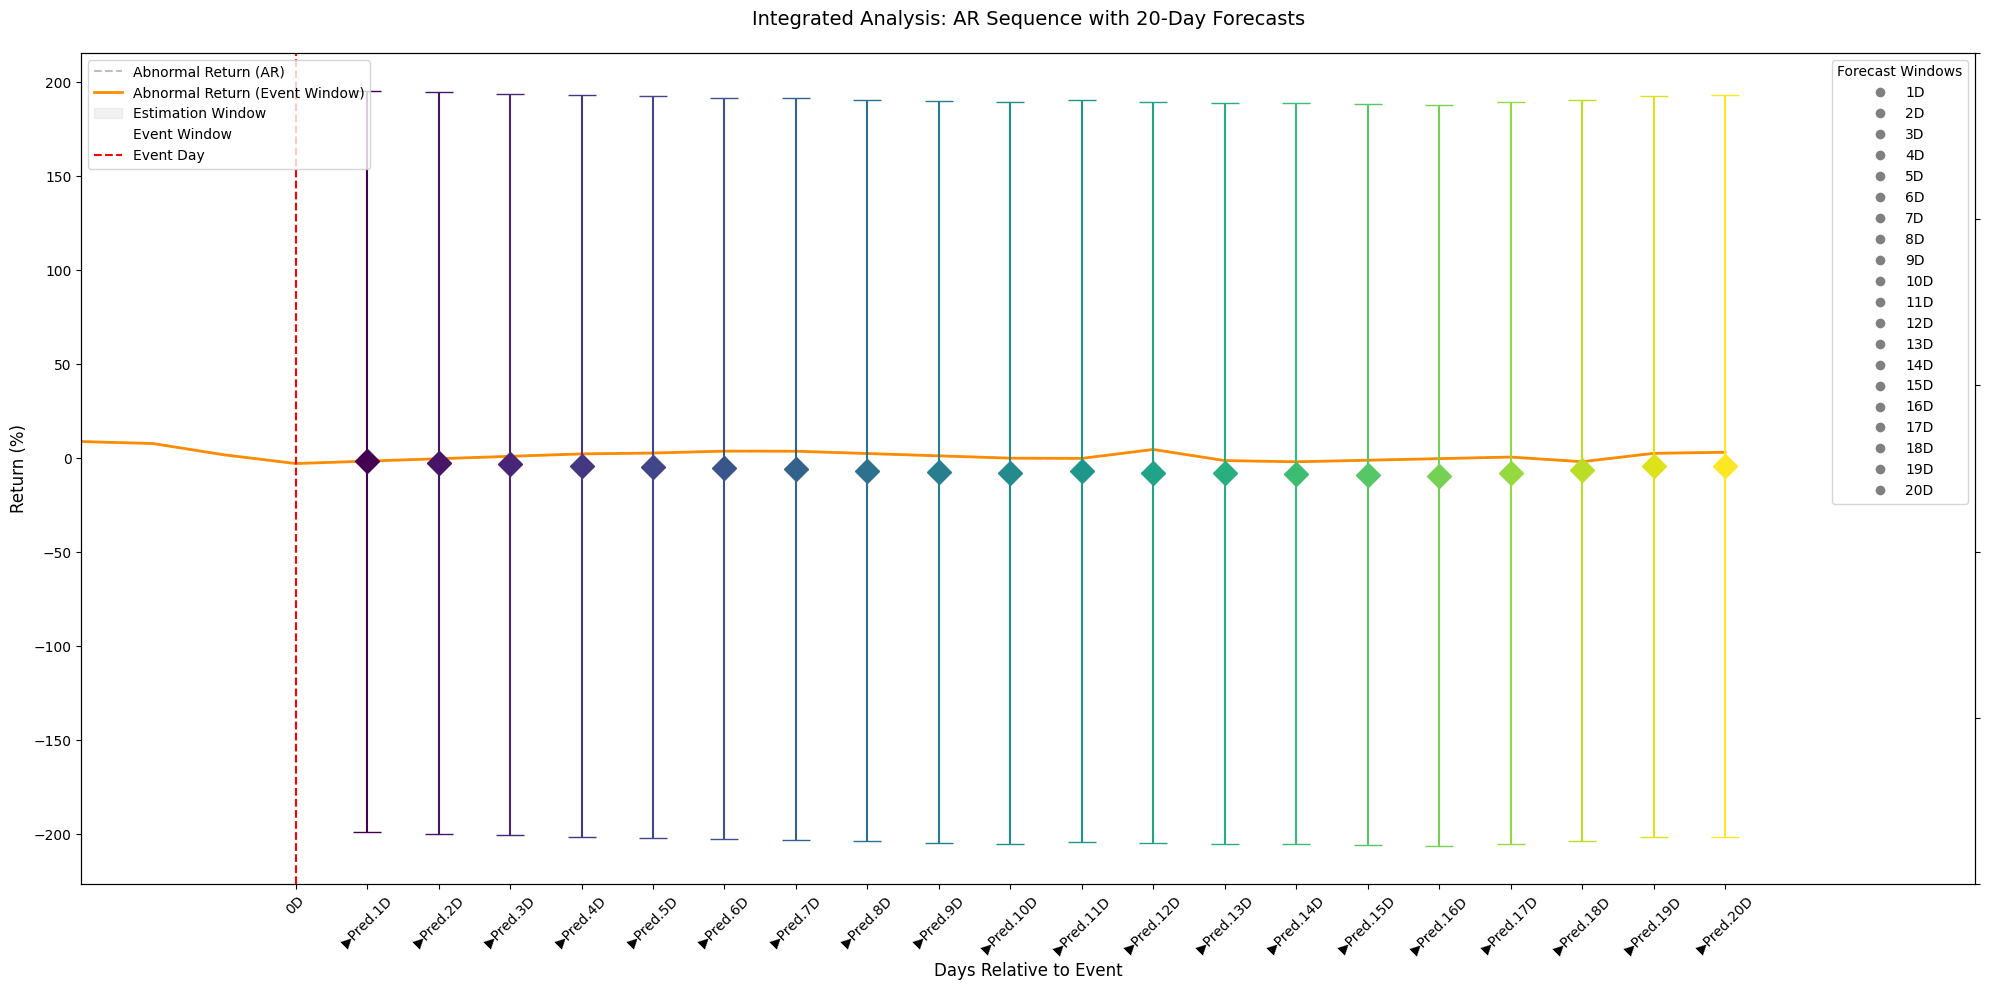

In [337]:
plot_ar_with_predictions(
    ar_df=filled_df,
    results=results_event,
    stock_id = '603608',
    event_date=nearest_event,
    est_window=(-50, -30),
    event_window=(-20, 20),
    windows=range(1, 21)
)

# 完整实现

In [34]:
def event_research_merge_data():
    financial_df = read_and_merge_financial_statements() #合并财务报表
    daily_returns_df = merge_trading_data() # 合并日个股收益率文件
    stock_df = merge_finance_and_trading_data(financial_df, daily_returns_df)
    trade_data_ff = merge_factor_trading_data(stock_df) # 合并个股收益率文件和日三因子文件
    merged_events, specific_columns_record = process_and_merge_files('firm_event') #合并公司事件文件 
    event_financial_data = merge_data(merged_events, trade_data_ff) #合并各类数据
    print("合并完成，结果已保存")
    return event_financial_data, specific_columns_record
event_financial_data, specific_columns_record = event_research_merge_data()

C:\Users\29229\AppData\Local\Temp\ipykernel_8392\3479750526.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trd_df['Trddt'] = pd.to_datetime(trd_df['Trddt'])


合并完成，结果已保存


In [ ]:
data = event_financial_data
stock_id = '603608'
event_type = 'buy_back_program'
given_date = '2024-06-09'
pre_window = 50
est_window = 30

In [48]:
nearest_event = find_nearest_event(event_financial_data, stock_id, event_type, given_date) #求最近日期
merged_data_with_ar = calculate_all_stocks_ar_inplace(event_financial_data, nearest_event, pre_window, est_window)# 添加ar列

C:\Users\29229\AppData\Local\Temp\ipykernel_38520\546559457.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_empty_data[marker_column] = pd.to_datetime(non_empty_data[marker_column])
C:\Users\29229\AppData\Local\Temp\ipykernel_38520\546559457.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_empty_data['date_diff'] = abs(non_empty_data['publish_at'] - given_date)
Processing Stocks: 100%|█████████████████████████████████████████████████████████| 5576/5576 [8:59:36<00:00,  5.81s/it]


In [543]:
def event_research_id_result(event_financial_data, merged_data_with_ar, specific_columns_record, stock_id, given_date, event_type, pre_window, est_window, window = 20, windows= list(range(1, 21))):
    nearest_event = find_nearest_event(event_financial_data, stock_id, event_type, given_date) #求最近日期
    filled_df = dynamic_fillna(merged_data_with_ar, window, event_type, specific_columns_record)
    event_results = event_analysis(filled_df, stock_id, nearest_event, pre_window, windows, event_type, specific_columns_record)
    predict_event_result = predict_return(event_results, merged_data_with_ar, stock_id, nearest_event, pre_window, windows) #此处eventdate可调，用于预测下次发生
    return predict_event_result

In [545]:
predict_event_result = event_research_id_result(event_financial_data, merged_data_with_ar, specific_columns_record, stock_id, given_date, event_type, pre_window, est_window)

C:\Users\29229\AppData\Local\Temp\ipykernel_38520\546559457.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_empty_data[marker_column] = pd.to_datetime(non_empty_data[marker_column])
C:\Users\29229\AppData\Local\Temp\ipykernel_38520\546559457.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_empty_data['date_diff'] = abs(non_empty_data['publish_at'] - given_date)
C:\Users\29229\AppData\Local\Temp\ipykernel_38520\546559457.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy o

C:\Users\29229\AppData\Local\Temp\ipykernel_38520\2703069339.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['days_from_event'] = (plot_df['Trddt'] - event_date).dt.days
C:\Users\29229\AppData\Local\Temp\ipykernel_38520\2703069339.py:65: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(*event_window, color='none', edgecolor='darkorange',


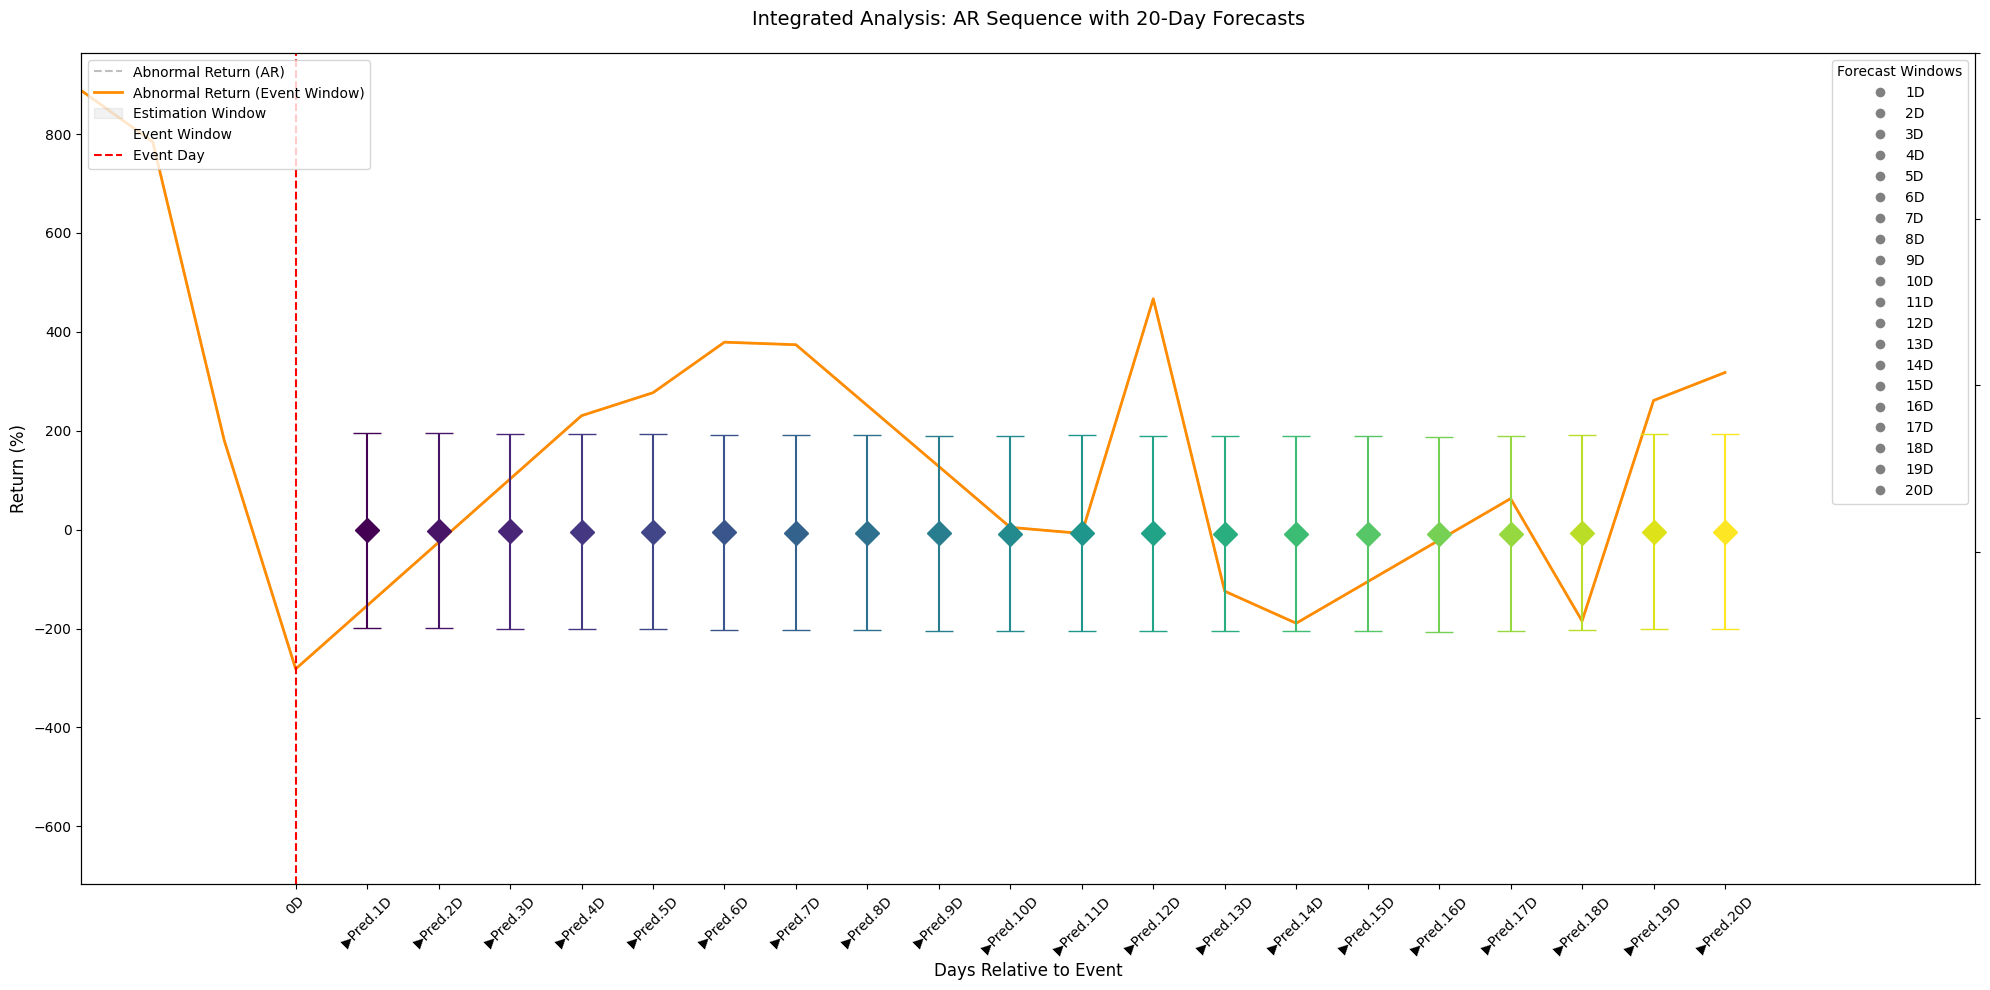

In [579]:
plot_ar_with_predictions(
    ar_df=filled_df,
    results=predict_event_result,
    stock_id = '603608',
    event_date=nearest_event,
    est_window=(-50, -30),
    event_window=(-20, 20),
    windows=range(1, 21)
)

### CAR（累积异常收益）详解

#### **1. CAR的定义**
**累积异常收益（Cumulative Abnormal Return, CAR）** 是事件研究中用于衡量特定事件（如并购、政策发布、高管变动等）对某只股票价格影响的指标。其核心思想是：在事件发生期间，股票的实际收益与预期正常收益（即若无事件发生时的收益）之间的差异的累积值。

**请注意：本代码采用AR作为因变量，但代码可以改写为CAR。**

#### **2. CAR的计算步骤**
**步骤1：确定事件窗口**
- **事件日（Day 0）**：事件发生的日期（如并购公告日）。
- **估计窗口**：事件发生前的一段时间（如事件前250天至前30天），用于计算预期正常收益的模型参数。
- **事件窗口**：围绕事件日的观察期（如事件前3天至后3天），用于计算异常收益。

**步骤2：计算正常收益**
通过以下模型之一估计股票的预期正常收益（即市场收益的线性关系）：
- **市场模型（Market Model）**：
  \[
  R_{it} = \alpha_i + \beta_i R_{mt} + \epsilon_{it}
  \]
  其中：
  - \( R_{it} \)：股票 \( i \) 在时间 \( t \) 的实际收益。
  - \( R_{mt} \)：市场指数（如标普500）在时间 \( t \) 的收益。
  - \( \alpha_i, \beta_i \)：通过估计窗口的回归得出。
  - 预期正常收益：\( \hat{R}_{it} = \hat{\alpha}_i + \hat{\beta}_i R_{mt} \)。

- **均值调整模型（Mean-Adjusted Model）**：
  预期正常收益为估计窗口内的平均收益：
  \[
  \hat{R}_{it} = \frac{1}{T} \sum_{t \in \text{估计窗口}} R_{it}
  \]

**步骤3：计算异常收益（AR）**
异常收益 = 实际收益 - 预期正常收益：
\[
AR_{it} = R_{it} - \hat{R}_{it}
\]

**步骤4：累积异常收益（CAR）**
将事件窗口内各天的异常收益相加：
\[
CAR_{i} = \sum_{t=T_1}^{T_2} AR_{it}
\]
其中，\( T_1 \) 和 \( T_2 \) 为事件窗口的起始和结束日。

---

#### **3. 因变量与自变量的定义**
在事件研究中，变量设计通常如下：
- **因变量（Dependent Variable）**：
  - **CAR**：事件窗口内的累积异常收益，用于衡量事件对公司价值的影响。
  - **单日AR**：事件日当天的异常收益（部分研究使用）。

- **自变量（Independent Variables）**：
  - **事件类型**：如并购是否为横向、混合并购（虚拟变量）。
  - **公司特征**：
    - 规模（Log(总资产)）、杠杆率（负债/资产）、盈利能力（ROA）。
    - 行业属性（如能源、科技行业的虚拟变量）。
  - **市场环境**：
    - 市场波动率（VIX指数）、利率水平（10年期国债收益率）。
  - **事件强度**：
    - 并购交易金额/公司市值、政策力度评分（文本分析生成）。

---

#### **4. 数据计算示例**
假设研究某次并购事件的影响：
- **数据获取**：
  - 股票日收益率数据（如雅虎财经）。
  - 市场指数日收益率（如标普500）。
  - 事件日期（如SEC公告日期）。

- **计算过程**：
  1. **估计窗口**：事件前250天至前30天。
  2. **回归市场模型**：
     - 得出 \( \hat{\alpha} = 0.001 \), \( \hat{\beta} = 1.2 \)。
  3. **事件窗口**：事件前1天至后1天（共3天）。
  4. **计算AR**：
     | 日期   | 实际收益（\( R_{it} \)） | 市场收益（\( R_{mt} \)） | 预期收益（\( \hat{R}_{it} \)） | AR（\( R_{it} - \hat{R}_{it} \)） |
     |--------|--------------------------|--------------------------|--------------------------------|-----------------------------------|
     | Day -1 | 1.5%                     | 0.8%                     | \( 0.001 + 1.2 \times 0.8\% = 1.06\% \) | \( 1.5\% - 1.06\% = 0.44\% \) |
     | Day 0  | 3.2%                     | 1.0%                     | \( 0.001 + 1.2 \times 1.0\% = 1.3\% \) | \( 3.2\% - 1.3\% = 1.9\% \) |
     | Day +1 | -0.5%                    | -0.2%                    | \( 0.001 + 1.2 \times (-0.2\%) = -0.14\% \) | \( -0.5\% - (-0.14\%) = -0.36\% \) |
  5. **计算CAR**：
     \[
     CAR = 0.44\% + 1.9\% + (-0.36\%) = 1.98\%
     \]

---

#### **5. 统计检验与结果解读**
- **显著性检验**：
  - **t检验**：检验CAR是否显著不等于零。
    \[
    t = \frac{\text{平均CAR}}{\text{标准误}} \quad (\text{如} \ t=2.33^{**})
    \]
  - **非参数检验**：如符号检验、秩和检验（适用于非正态分布数据）。

- **结果解释**：
  - **CAR显著为正**：事件（如并购）被市场解读为利好。
  - **CAR显著为负**：事件（如财务造假曝光）导致价值损失。
  - **CAR不显著**：事件影响中性或信息已被市场提前消化。

---

#### **6. 注意事项与改进方法**
- **窗口选择敏感性**：
  - 过长事件窗口可能包含噪音（如其他事件干扰）。
  - 改进：使用动态窗口或分阶段分析（如[-1,+1]与[+2,+5]分开）。

- **模型选择影响**：
  - 市场模型假设线性关系，可能忽略非线性因素。
  - 改进：采用多因子模型（Fama-French三因子）或机器学习预测正常收益。

- **异方差与自相关**：
  - 使用Newey-West调整标准误，处理时间序列相关性。

- **样本选择偏差**：
  - 排除同时期发生其他重大事件的公司。

---

### **总结**
CAR通过量化事件窗口内的异常收益累积值，成为金融研究中的核心工具。其计算需严谨选择模型、窗口和检验方法，自变量设计需结合研究问题（如公司特征或事件属性）。实际应用中，需处理数据质量、模型假设及统计稳健性问题，以确保结论可靠性。